<a href="https://colab.research.google.com/github/TechDailyNotes/study-notes-triton/blob/main/practice_02_fused_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly

Looking in indexes: https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 MB 10.7 MB/s eta 0:00:00


In [2]:
import torch
import triton
import triton.language as tl
from triton.runtime import driver

def naive_softmax(x):
    # Step 1: Shift x to prevent overflow.
    # MN reads, M writes.
    x_max = x.max(dim=1)[0]
    # MN + M reads, MN writes.
    x_shift = x - x_max[:, None]

    # Step 2: Compute softmax.
    # MN reads, MN writes.
    numerator = x_shift.exp()
    # MN reads, M writes.
    denominator = numerator.sum(dim=1)
    # MN + M reads, MN writes.
    retval = numerator / denominator[:, None]
    # In total, 5MN + 2M reads, 3MN + 2M writes.
    return retval

In [3]:
@triton.jit
def softmax_kernel(
    input_ptr, output_ptr, num_rows, num_cols, row_stride,
    BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr,
):
    # Step 1: Get the thread parameters.
    row_index_start = tl.program_id(0)
    row_index_end = num_rows
    row_index_step = tl.num_programs(0)

    for row_index in tl.range(
        row_index_start, row_index_end, row_index_step, num_stages=num_stages,
    ):
        # Step 2: Load data.
        input_ptr_start = input_ptr + row_index * row_stride
        input_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = input_ptr_start + input_offsets
        input_mask = input_offsets < num_cols
        input_row = tl.load(input_ptrs, mask=input_mask, other=float("-inf"))

        # Step 3: Compute data.
        input_row_shift = input_row - tl.max(input_row, axis=0)
        numerator = tl.exp(input_row_shift)
        denominator = tl.sum(numerator, axis=0)
        output_row = numerator / denominator

        # Step 4: Store data.
        output_ptr_start = output_ptr + row_index * row_stride
        output_offsets = tl.arange(0, BLOCK_SIZE)
        output_ptrs = output_ptr_start + output_offsets
        output_mask = output_offsets < num_cols
        tl.store(output_ptrs, output_row, mask=output_mask)

In [4]:
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
target = driver.active.get_current_target()

MAX_SHARED_MEM = properties["max_shared_mem"]
MAX_NUM_REGS = properties["max_num_regs"]
WARP_SIZE = properties["warpSize"]
SM_COUNT = properties["multiprocessor_count"]

kernels = {}

def softmax(x):
    # Step 1: Init output.
    y = torch.empty_like(x)

    # Step 2: Set kernel parameters.
    num_rows, num_cols = x.shape
    row_stride = x.stride(0)

    BLOCK_SIZE = triton.next_power_of_2(num_cols)
    num_stages = 4 if MAX_SHARED_MEM > 200000 else 2
    num_warps = 8

    # Step 3: Launch kernel function.
    if BLOCK_SIZE not in kernels:
        kernel = softmax_kernel.warmup(
            x, y, num_rows, num_cols, row_stride, BLOCK_SIZE=BLOCK_SIZE,
            num_stages=num_stages, num_warps=num_warps, grid=(1, ),
        )
        kernel._init_handles()
        occupancy = min(
            MAX_NUM_REGS // (num_warps * WARP_SIZE * kernel.n_regs),
            MAX_SHARED_MEM // kernel.metadata.shared,
        )
        num_programs = SM_COUNT * occupancy

        kernels[BLOCK_SIZE] = (kernel, num_programs)

    kernel, num_programs = kernels[BLOCK_SIZE]
    kernel[(num_programs, 1, 1)](x, y, num_rows, num_cols, row_stride)

    return y

In [5]:
torch.manual_seed(0)

x = torch.randn((1823, 781), dtype=torch.float32, device="cuda")
output_triton = softmax(x)
output_torch = torch.softmax(x, axis=1)

print(f"max diff = {torch.max(torch.abs(output_triton - output_torch))}")
assert \
    torch.allclose(output_triton, output_torch), \
    (f"output_triton = {output_triton}", f"output_torch = {output_torch}")
print("success")


max diff = 7.450580596923828e-09
success


In [8]:
@triton.testing.perf_report(triton.testing.Benchmark(
    x_names=["N"], x_vals=[128 * i for i in range(10, 100)], line_arg="provider",
    line_vals=["triton", "torch"], line_names=["Triton", "Torch"],
    ylabel="GB/s", styles=[("blue", "-"), ("green", "-")],
    plot_name="fused softmax performance", args={"M": 4096},
))
def benchmark(M, N, provider):
    # Step 1: Init input.
    x = torch.randn((M, N), dtype=torch.float32, device="cuda")

    # Step 2: Set benchmark parameters.
    quantiles = [0.5, 0.2, 0.8]

    # Step 3: Launch benchmark function.
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: softmax(x), quantiles=quantiles,
        )
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.softmax(x, axis=1), quantiles=quantiles,
        )

    # Step 4: Compute throughput.
    gbps = lambda ms: x.numel() * x.element_size() * 2 / ms * 1e-6
    return gbps(ms), gbps(min_ms), gbps(max_ms)

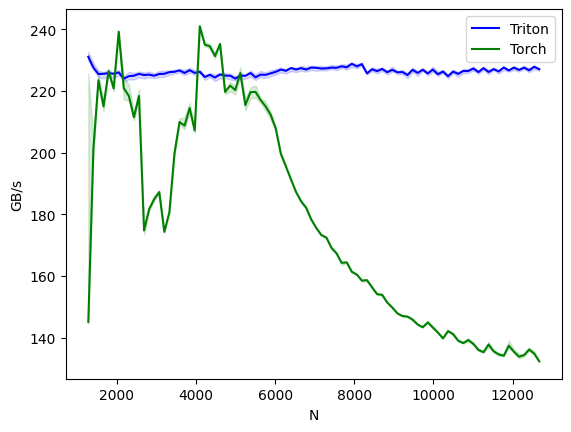

fused softmax performance:
          N      Triton       Torch
0    1280.0  231.065668  145.135650
1    1408.0  227.555562  201.227080
2    1536.0  225.467889  223.497551
3    1664.0  225.552455  214.980563
4    1792.0  225.763768  226.432372
5    1920.0  225.558438  220.796228
6    2048.0  225.986210  239.182490
7    2176.0  223.975887  220.878658
8    2304.0  224.780491  218.392667
9    2432.0  224.924864  211.478256
10   2560.0  225.519614  218.344167
11   2688.0  225.154352  174.773763
12   2816.0  225.280006  181.677422
13   2944.0  224.923967  184.919860
14   3072.0  225.492138  187.212282
15   3200.0  225.550664  174.316424
16   3328.0  226.091150  180.673950
17   3456.0  226.210105  199.737213
18   3584.0  226.642121  209.907116
19   3712.0  225.825100  208.753494
20   3840.0  226.709320  214.438565
21   3968.0  225.841759  207.165058
22   4096.0  226.217778  240.941172
23   4224.0  224.519909  234.985383
24   4352.0  225.203932  234.451185
25   4480.0  224.339582  231.266601
2

In [9]:
benchmark.run(show_plots=True, print_data=True)